In [ ]:
import numpy as np
import sisl
import sisl.viz
import plotly.express as px

Our problem: The Schrödinger equation
-----

The problem that we need to solve in order to get the electronic structure of a system is the Schrödinger equation:

$$H\psi = E \psi$$

where $H$ is the Hamiltonian -an operator that somehow encodes the interactions in the system-, $\psi$ are the electronic ground states (wavefunctions), and $E$ are the energies of those states.

During the notebook, we are going to see how does SIESTA tackle this problem in practice. While doing so, we hope to understand what the main parameters in `SIESTA` mean, so that we can be confident that our results are meaningful.

#### A recursive problem

The nature of this problem is recursive. The Hamiltonian encodes how different parts of the system interact. It is easy to imagine that this interaction depends on where the electrons are located, i.e. the electronic density ($\rho$). The electronic density is computed from the wavefunctions ($\phi$). However, to obtain the wavefunctions you need the Hamiltonian so that you can solve the Schrödinger equation. Therefore, we have a cycle:

$$H_1 \rightarrow \psi_1 \rightarrow \rho_1 \rightarrow H_2 \rightarrow \psi_2 \rightarrow \rho_2 \rightarrow ... \rightarrow H_{n-1} \rightarrow \psi_{n-1} \rightarrow \rho_{n-1} \rightarrow H_n \rightarrow \psi_n \rightarrow \rho_n$$

What we do in practice is to start with a (hopefully good) guess. Then repeat the cycle until we reach **self-consistency**. We consider that we have reached self-consistency when values are very similar between cycles, e.g. $|H_n - H_{n-1}| < 0.0001$.

*When you run SIESTA, try to spot this cycle in the output file!*

How SIESTA solves it
---

### 1. Basis functions

The first step to understand how SIESTA solves this problem is to understand what basis functions are, and why are they useful.

Let's use the hydrogen molecule ($H_2$) as an example:

In [ ]:
# Create a H2 molecule, specifying the positions.
H_molec = sisl.Geometry(xyz=[[2,2.5,0], [3, 2.5, 0]], atoms="H")

In [ ]:
# Plot it to check that it has been properly built
H_molec.plot(axes="xy", atoms_scale=3, show_cell=False)

Now, the wavefunctions (HOMO and LUMO) of the hydrogen molecule look like this:

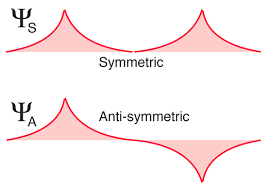

So, what should we do? Do we **store the value of each wavefunction at each point of space** (in 3D)? The answer is **NO, WE DON'T**, because that would require us to use **A LOT of memory** and computations would take **A VERY LONG TIME**. It also makes it hard to solve the problem.

What we do instead is to use basis functions ($\phi$). We then combine these basis functions to describe the wavefunctions ($\psi$). In this way, all we need to fully describe the wavefunctions are some coefficients ($c$), instead of the value of the wavefunction at each point of space.

For a simple basis for $H_2$, it feels natural to define two basis functions, one centered at each atom. We will call them {$\phi_0, \phi_1$}. 

In [ ]:
# Sampling of space
x = np.arange(0, 5, 0.02)

# Define the two basis functions as gaussians centered on each atom
orbital0 = sisl.gaussian(x, sigma=0.3 ,x0=H_molec[0, 0]) 
orbital1 = sisl.gaussian(x, sigma=0.3 ,x0=H_molec[1, 0])

# Plot the structure
figure = H_molec.plot(axes="xy", atoms_scale=3, show_cell=False)

# And the basis functions on top, using a secondary axis
figure.add_scatter(
    x=x, y=orbital0, yaxis="y2", line_color="blue", name="Φ_0"
).add_scatter(
    x=x, y=orbital1, yaxis="y2", line_color="red", name="Φ_1"
).update_layout(
    yaxis2 = {"side":'right', 'overlaying': 'y', 'title': "Orbital value"},
    height=500
)

We can then define two wavefunctions:

$$\psi_0 = \phi_0 + \phi_1$$

$$\psi_1 = \phi_0 - \phi_1$$

In [ ]:
# Define the wavefunctions
wf0 = orbital0 + orbital1
wf1 = orbital0 - orbital1

# Plot the structure
figure = H_molec.plot(axes="xy", atoms_scale=3, show_cell=False)

# And the wavefunctions on top, using a secondary axis
figure.add_scatter(
    x=x, y=wf0, yaxis="y2", line_color="blue", name="Ψ_0 = Φ_0 + Φ_1"
).add_scatter(
    x=x, y=wf1, yaxis="y2", line_color="red", name="Ψ_1 = Φ_0 - Φ_1"
).update_layout(
    yaxis2 = {"side":'right', 'overlaying': 'y', 'title': "Orbital value"},
    height=500
)

Are they similar to the *"real"* wavefunctions in the picture above? You could say they are fairly similar. Note that there has been a huge gain though, since we now wavefunctions can be fully described just with:

$$\psi_0 = (1, 1), \psi_1 = (1, -1)$$

instead of storing the value on each grid point:

$$\psi_0(r) = [0, 0, 0.3, 0.4, 0.6, ..., 0.4, 0, 0, 0, 0]$$

The benefits of this grow with system size, specially for localized basis functions (e.g. centered on atoms). Furthermore, defining states in terms of basis functions helps in solving the electronic structure, as well as in analyzing results.

So it seems clear that basis functions can be helpful, but they are only useful if you choose them properly. The question is then:

**WHAT MAKES A GOOD BASIS SET?**

A good basis set is one that can **reproduce the real wavefunctions** of the system with a **small number of basis functions**. If your basis functions can not describe the real solution, you'll get a solution that doesn't make sense.

Finally, once we have the wavefunctions, we can compute the electronic density by summing their squares:

$$\rho = n_0\psi_0^2 + n_1\psi_1^2 $$

In [ ]:
# Define the occupation of each wavefunction
n0 = 1
n1 = 0

# And compute the electronic density
electronic_density = n0 * wf0 ** 2 + n1 * wf1 ** 2

# Plot the structure
figure = H_molec.plot(axes="xy", atoms_scale=3, show_cell=False)

# And the electronic density on top, using a secondary axis
figure.add_scatter(
    x=x, y=electronic_density, yaxis="y2", line_color="blue", name=r"ρ = n_0(Ψ_0)^2 + n_1(Ψ_1)^2 $"
).update_layout(
    yaxis2 = {"side":'right', 'overlaying': 'y', 'title': "Orbital value"},
    height=500
)

In summary:

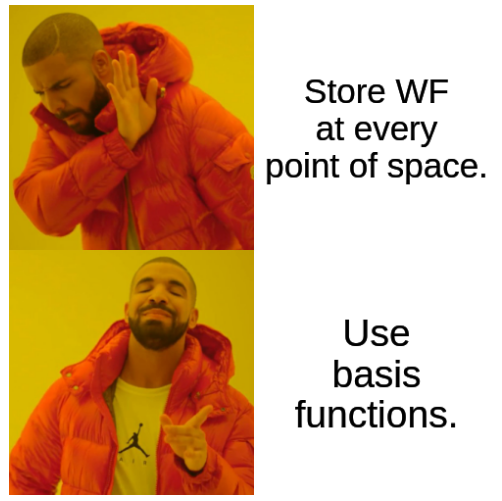

But you must choose your basis wisely.

The general formulas for wavefunctions and electronic density are:

$$ \psi_i = \sum_jc_{ij}\phi_j$$

$$ \rho = \sum_in_i\psi_i^2 = \sum_in_i\left(\sum_jc_{ij}\phi_j\right)^2$$

If you go through them and end up understanding them, it means you understand perfectly the concept of basis functions to describe electronic structure!

**MAIN PARAMETERS THAT CONTROL THE BASIS SET IN SIESTA:**

- **PAO.BasisSize**: Controls the number of basis functions of each atom.
- **PAO.EnergyShift**: Controls the reach of each basis function. I.e. how far into space they extend.

### 2. Schrödinger equation with basis functions

Let's go back to our problem, the Schrödinger equation:

$$H\psi = E \psi$$

We have seen that we can describe a wavefunction as a vector of coefficients thanks to basis functions: 

$$\psi_0 = \begin{bmatrix}
c_{00} & c_{01}
\end{bmatrix}$$

In a similar way, we can define the Hamiltonian as a matrix of interactions between basis functions:

$$
H = \begin{bmatrix}
H_{00} & H_{01} \\
H_{10} & H_{11}
\end{bmatrix}
$$

where each $H_{ij}$ encodes the interaction energy between basis $\phi_i$ and $\phi_j$. The diagonal terms are called *on-site terms*, and the *off-diagonal* are usually referred to as *hoppings*.

Then, the problem becomes an **eigenvalue problem**, where you have to find the eigenvalues ($E$) and eigenvectors ($\psi$) of the matrix $H$.

As an example, in a system of two hydrogen atoms that are very far from each other, the Hamiltonian would be:

$$
H = \begin{bmatrix}
E_H & 0 \\
0 & E_H
\end{bmatrix}
$$

where $E_H$ is the energy of the $H$ atom. The non diagonal elements are 0 because the basis functions are so far that they don't interact.

What are the eigenvectors and eigenvalues of this Hamiltonian? Are they what you would expect from this system?

In [ ]:
# Define the energy of a hydrogen atom.
E_H = -3.5

# Build the hamiltonian
H = np.array([[E_H, 0], [0, E_H]])

# Extract eigenvalues and eigenvectors.
np.linalg.eig(H)

**Exercise:** Imagine we start to bring the atoms closer together. Qualitatively, how would you modify the Hamiltonian to account for this fact? Apply the modification and see how eigenvalues and eigenstates change. Is this what you would expect?

### 3. Solids are infinite systems. Periodicity comes to rescue.

The things described until now sound good and simple. But things start to get complicated when we consider the simplest of solids: A chain of hydrogen atoms.

In [ ]:
H_chain = sisl.Geometry(xyz=[[0,2.5,0], [1, 2.5, 0]], atoms="H", lattice=[2,5,5])
H_chain.set_nsc([3, 1, 1])

H_chain.plot(axes="xy", nsc=[20, 1, 1], atoms_scale=2).update_layout(
    xaxis_range=[10, 25],
)

This is an infinite system. So we have an **infinite number of basis functions**!!

Suddenly, we are faced with the fact that we **can not build a Hamiltonian matrix of infinite size to get eigenstates of infinite length**.

Luckily, most solids have very high symmetry, and we can identify a unit that gets repeated periodically, we call this the **unit cell**:

In [ ]:
H_chain.plot(axes="xy", nsc=[5, 1, 1], atoms_scale=2)

Note that the choice of unit cell is arbitrary. We have here chosen the unit cell to contain 2 atoms in analogy with the $H_2$ molecule, but we could have chosen a unit cell with 1, 3, 4... atoms.

Once we choose the unit cell, we tell SIESTA that we want to work with this unit cell, and SIESTA will *always* assume periodicity. Therefore, it will do a simulation of our infinite system for the price of simulating only 2 atoms (kind of).

### 4. The atoms distribute periodically. Are electron states also periodic? Bloch Theorem.

The atomic structure can be described as a unit that repeats periodically. This creates a periodic potential. But now, we need to fill the space with electrons. The electrons' behavior is described by their wavefunctions. Are their wavefunctions also periodic? The answer is **NO**.

**Electronic states are not constrained to stay in distributions with the same periodicity as our unit cell**. One can reach this conclusion naturally by considering that only two electrons (spin up and down) can fill a given electronic state, and we have an infinite number of electrons.

What do we do now? We need to go back to simulating the infinite system?!?! Luckily we don't.

**Bloch's theorem** describes how electronic states distribute on a periodic potential:

$$\psi(\mathbf{r}) = e^{i\mathbf{k}\mathbf{r}}u(\mathbf{r})$$

where $u(\mathbf{r})$ is a function that is periodic with the same periodicity as the potential (i.e. period = unit cell). The wavefunction is then a product of this function by a planewave ($e^{i\mathbf{k}\mathbf{r}}$). $\mathbf{k}$ is a vector of reciprocal space.

In fact, in our one dimensional case, this reduces to:

$$\psi(x) = e^{ik_xx}u(x)$$

Let's play a bit with the idea, to see how the wavefunctions change. Note that we need to display more than one unit cell, since wavefunctions no longer have the same periodicity as the potential.

In [ ]:
# Number of unit cells that we will display in the X direction
nsc = 10

# Plot the structure, we will draw things on top of it.
figure = H_chain.plot(axes="xy", nsc=[nsc, 1, 1], atoms_scale=2, show_cell="box")

# The lattice constant of our H chain.
lattice_a = H_chain.cell[0, 0]

# Some sampling of space, with a 0.02 Ang precision.
x = np.arange(0, lattice_a * nsc, 0.02)

# Now, we start to build our wavefunction
# First, we build a function with the same periodicity as the atomic potential.
u = np.sin(x / lattice_a * 2 * np.pi + np.pi / 2)

# Now, we choose a value for k and build a planewave. The first brillouin zone goes from -pi/a to pi/a.
k = 1 * np.pi / lattice_a
pw = np.exp(1j * k * x)

# Finally, we build the wavefunction as a product of the two.
wf = u * pw 

# We draw each component of the wf and the wf itself
figure.add_scatter(
    x=x, y=u, yaxis="y2", line_color="blue", name="Periodic part"
).add_scatter(
    x=x, y=pw.real, yaxis="y2", line_color="red", name="Plane wave"
).add_scatter(
    x=x, y=wf.real, yaxis="y2", line_color="purple", name="Wavefunction"
).add_scatter(
    x=x, y=(wf.conj() * wf).real, yaxis="y2", line_color="orange", name="Electronic density", 
    visible="legendonly",
).update_layout(
    yaxis2 = {"side":'right', 'overlaying': 'y'},
    height=500
)

This is great!! If it wasn't for this, we would have to describe wavefunctions in **INFINITE SPACE**!! Instead, we describe them using a plane wave with a certain $\vec{k}$. Just to make reciprocal space simpler to understand, so that you can appreciate this nice theorem: this is like the difference between describing a musical note with the value of the vibration at each point in time (real space) or just with just a number, the frequency (reciprocal space). 

The price we have to pay, though, is that we have to account for all the possible $\vec{k}$s. Since each $\vec{k}$ will result in a different wavefunction, it will also result in a different energy. In fact, the Schrödinger equation then becomes:

$$H_k\psi_k = E_k \psi_k$$

The final properties of the system are an average of all the possible distributions of electrons. Therefore, we need to appropiately sample reciprocal space and take an average of all points. In fact, we **TAKE AN AVERAGE OVER THE BRILLOUIN ZONE**.

As an example of how the energy of wavefunctions depend on $\mathbf{k}$, here is the band structure of a 1D hydrogen chain:

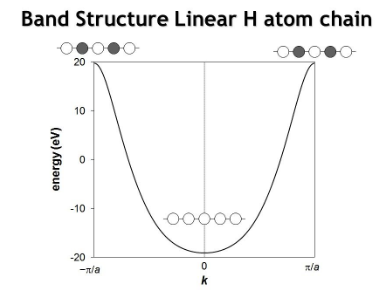

As a summary of Bloch's theorem:

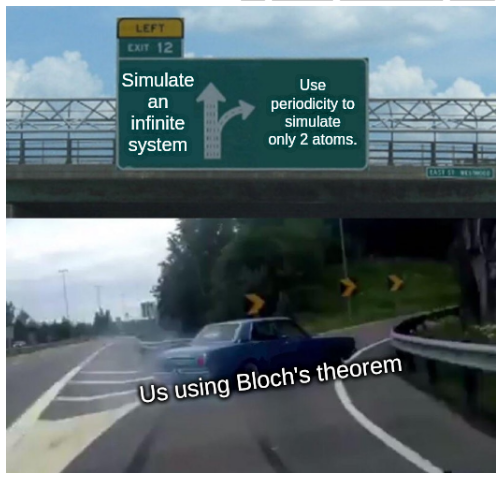

**MAIN PARAMETER THAT CONTROLS THE RECIPROCAL SPACE SAMPLING IN SIESTA:**

**kgrid.MonkhorstPack**: A block specifying the grid of k points to sample reciprocal space. As an example:
```
%block kgrid.MonkhorstPack
   3 0 0  0
   0 5 0  0
   0 0 7  0
%endblock kgrid.MonkhorstPack
```

means that we are creating a uniform grid of 3x5x7 k points to sample reciprocal space. The center of the grid is (0, 0, 0), as indicated by the last column. 

### Converging SIESTA parameters

We have seen that setting the right parameters is key to having meaningful results with SIESTA calculations. In this notebook we have seen some of the most important ones: **PAO.BasisSize** and **PAO.EnergyShift** to control the basis, **kgrid.MonkhorstPack** to control the sampling of reciprocal space. The other most typical parameter that you need to tune is **MeshCutoff**, a parameter that defines the fineness of the real space grid that is used to compute electrostatic forces, amongst other things.

These parameters define the precision of the simulation. Ideally, you would like to crank them up to have the best precision, but that results in higher and higher computational costs. Therefore, we need to find a compromise between precision and speed.

The first thing you must do before taking your results seriously is to make sure that **your results are converged**. That is, checking that if we improve some parameter the results don't change significantly. You must always do a convergence study. In a convergence study, you start with some low precision parameters and you progressively turn them up until you see that the results are no longer affected.

### Today's exercise: Converge the parameters for a graphene calculation

Do a **convergence study** for the 4 parameters mentioned in the previous section and determine what are some **suitable parameters to perform further calculations on graphene**.

*Note: Look for them in SIESTA's manual.*

To do this, we will **track the total energy of the system** as we tune the parameters, and we will consider the parameter converged when the energy doesn't change "much" (up to you to decide).

In the `convergence/inputs` folder you will find a pseudopotential for C (*C.psf*), the only atom present in graphene. We are also going to create a graphene structure and save it into that folder.

In [ ]:
# Create a graphene structure with the default parameters.
graphene = sisl.geom.graphene()
# Plot it to see that it is what we wanted
graphene.plot(axes="xy")

In [ ]:
# Some extra packages that we will need for this part
from pathlib import Path
import os

# Now write the graphene structure into an fdf file, geom.fdf
# You can check the file
inputs_dir = Path("convergence/inputs")
graphene.write(inputs_dir / "geom.fdf")

Now we have all the minimal inputs that we need to run a simulation: the structure and the pseudopotentials. We can start the convergence study.

Below you can find an example of how one might handle the creation of inputs for multiple simulations. Where we do the convergence study for the basis size:

In [ ]:
# Define the root directory for the convergence study for basis size
root = Path("convergence/basis")
# Create the directory if it doesn't exist
root.mkdir(exist_ok=True)

# Define all the basis sizes that we want to try.
basis_sizes = ['SZ', 'SZP', 'DZ', 'DZP', 'TZ', 'TZP']

# Start looping over them
for basis_size in basis_sizes:
    # Inform what is the current basis size.
    print(f"RUNNING SIMULATION FOR BASIS: {basis_size}")
    
    # Define the directory for this basis size, and create it if it doesn't exist
    basis_dir = root / basis_size
    basis_dir.mkdir(exist_ok=True)
    
    # Copy inputs from the inputs directory into this one.
    os.system(f"cp {inputs_dir}/* {basis_dir}")
    
    # Inside this directory, open a RUN.fdf file, which will be our main input file. 
    with open(basis_dir / 'RUN.fdf', 'w') as f:
        # We include the fdf file that contains the geometry, with the %include statement
        # Note the \n, which means "new line" in text files.
        f.write("%include geom.fdf \n")
        # We now include the basis size input.
        f.write(f"PAO.BasisSize {basis_size}")
    
    # We have the directory set up, we can run the siesta calculation. You might need
    # to tweak the siesta_path to the path where SIESTA is in your computer.
    # Alternatively, you can now go into each directory and run SIESTA manually.
    siesta_path = "siesta" #...write siesta path here
    os.system(f"cd {basis_dir}; {siesta_path} RUN.fdf > RUN.out")
    

Once all our simulations have run, we can gather the energies:

In [ ]:
# Initialize an empty list to store the energies.
Es = []

# Loop over basis sizes
for basis_size in basis_sizes:
    # Define the directory where this basis size calculation has run.
    basis_dir = root / basis_size
    
    # Initialize a parser for the output file (RUN.out) with sisl. From
    # this, we will be able to read many things that are written there.
    # See docs: https://zerothi.github.io/sisl/api/io/generated/sisl.io.siesta.outSileSiesta.html#sisl.io.siesta.outSileSiesta
    out_file = sisl.get_sile(basis_dir / "RUN.out", cls=sisl.io.stdoutSileSiesta)
    # We read all the energies. This is a dictionary containing different
    # energies, you can print it to see how it looks like.
    energies = out_file.read_energy()
    
    # In particular, we care about the total energy, which we get and store in the list
    Etot = energies['total']
    Es.append(Etot)

Now that we have gathered all the energies we can plot them however we want. Below, we do it with `plotly.express` (`px`):

In [ ]:
px.line(
    y=Es, x=basis_sizes, markers=True
).update_layout(
    title="Convergence of energy with basis size",
    xaxis_title="Basis size",
    yaxis_title="Energy [eV]"
)

To further decide what is the right value of a parameter, it is also nice to plot the time it took for the simulation to run. This is printed in the output file next to the words `"Elapsed wall time"`.